# Project 2 Milestone 1: Beam in Tension
## By Luke LaLonde and Bhargav Chandaka

### Creating a cosserat rod class

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import time

# This class is not completely general: only supports uniform mass and single radius and is initialized for the beam in tension problem
class cosserat_rod:
    # initialize the rod
    def __init__(self, n_elements: int = 100, tot_length = 3.0, rod_density = 5E3, 
                 rod_radius = 0.25, E = 1E6, G = 1E4, velocities = 0, internal_forces = 0):
        
        '''Set up quantities that describe the rod'''
        self.tot_length = tot_length
        self.G = G
        self.E = E
        self.n_elements = n_elements
        self.n_nodes = self.n_elements+1
        element_length = tot_length/n_elements

        # straight rod
        self.positions = np.vstack((np.zeros((2,self.n_nodes)),np.arange(0.0, tot_length+element_length, element_length)))
        
        self.lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)
        self.reference_lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.reference_lengths_norm = np.linalg.norm(self.reference_lengths_bold, axis=0, keepdims=True)
        
        # Use same director initialization from other milestones
        self.directors = np.zeros((3, 3, self.n_elements))
        self.directors[2] = self.lengths_bold/self.lengths_norm
        self.directors[1] = [[0]*self.n_elements, [1]*self.n_elements, [0]*self.n_elements]
        self.directors[0] = np.transpose(np.cross(self.directors[1], self.directors[2], 0, 0))
        
        self.rod_area = np.pi*rod_radius*rod_radius
        self.areas = self.rod_area*np.ones(self.n_elements,)
        
        element_mass = rod_density*element_length*self.rod_area
        self.masses = element_mass*np.ones(self.n_nodes,)
        self.masses[0] *= 0.5
        self.masses[-1] *= 0.5
       
        
        '''Set up quantities that will capture motion'''
        
        self.velocities = velocities if velocities else np.zeros((3, self.n_nodes)) 
        self.internal_forces = internal_forces if internal_forces else np.zeros((3, self.n_nodes))
        
        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        
        self.shear_stiffness_matrix = np.zeros((3, 3, n_elements)) # S
        alpha_c = 4.0 / 3.0
        self.shear_stiffness_matrix[0, 0, :] = alpha_c * self.G * self.areas # S1
        self.shear_stiffness_matrix[1, 1, :] = alpha_c * self.G * self.areas # S2
        self.shear_stiffness_matrix[2, 2, :] = self.E * self.areas # S2
        
        self.tangents = self.lengths_bold / self.lengths_norm   
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]    

            
    def deltaH_operator(self, t_x):
        """"""
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return temp - np.roll(temp, 1, t_x.ndim - 1)
    
    def Newton2(self, temp_x):
        """ Updates Translational Equations
        F = ma type calculations - key is to use position at half time step to recalc internal forces, then a"""
        self.lengths_bold = temp_x[:, 1:] - temp_x[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)

        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        self.tangents = self.lengths_bold / self.lengths_norm
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :] # will need to change also in time
        
        self.internal_forces = np.zeros((3,self.n_elements))
        
        self.internal_forces = np.einsum('ijk, jk-> ik', self.shear_stiffness_matrix, self.shear_stretch_strains)/ self.dilatations
        node_forces = self.deltaH_operator(self.internal_forces)
        
        # Potential Damping implementation
#         for elem in range(self.n_elements):
#              self.internal_forces[:,elem] = self.shear_stiffness_matrix[:, :, elem] @ \
#              self.shear_stretch_strains[:,elem] / self.dilatations[0,elem]
#         node_forces = self.modified_diff(self.internal_forces)
        
#         nu = 0.3
#         elem_vels = (self.velocities[:,1:] + self.velocities[:,:-1])/2
#         damping = -elem_vels*self.lengths_bold*nu
#         damping = self.modified_diff(damping)
        dvdt = (node_forces + self.ext_forces) / self.masses    
        return dvdt

    def position_verlet(self, dt, x, v, force_rule):
        """Position Verlet Timestepper which updates state variables at the half timestep"""
        temp_x = x + 0.5*dt*v
        v_n = v + dt * force_rule(temp_x)
        self.velocities[:,0] = np.zeros(3,)
        x_n = temp_x + 0.5 * dt * v_n
        self.positions[:,0] = np.zeros(3,)
        return x_n, v_n


    def run(self, ext_forces, t_total = 100, dt = 3E-4):
        """ Runs the simulation, specifying external conditions ** for now it's just for first benchmark"""
        self.ext_forces = ext_forces
        n_iterations = int(np.ceil(t_total/dt))
        self.position_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        for time_step in range(n_iterations):
            self.positions, self.velocities = self.position_verlet(dt, self.positions, self.velocities, self.Newton2)

            # constrain the first element to the wall
            self.positions[:,0] = np.zeros(3,)
            self.velocities[:,0] = np.zeros(3,)
            
            self.position_history[:, :, time_step] = self.positions
        
        print()
        print('Theoretical displacement (m): ', end = '')
        print(ext_forces[-1,-1]*self.tot_length/(self.E*self.rod_area-ext_forces[-1,-1]))
        print()
        print('Average end displacement (m): ', end = '')
        print(np.mean(self.position_history[-1,-1,:]-self.position_history[-1,-1, 0]))
        print()
        return (self.positions, self.position_history)


### Running the Simulation 

In [6]:
# Milestone 1
stretch_case = cosserat_rod(1)
t_total = 100
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)


Theoretical displacement (m): 0.00022920062769050053

Average end displacement (m): 0.0002290149695530267



### Plotting the End Node Position Results

Text(0, 0.5, 'X-Position(m)')

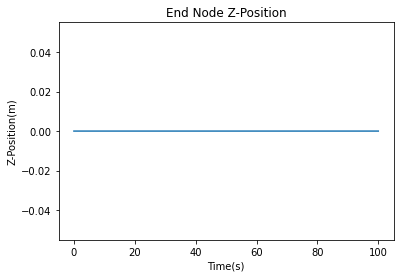

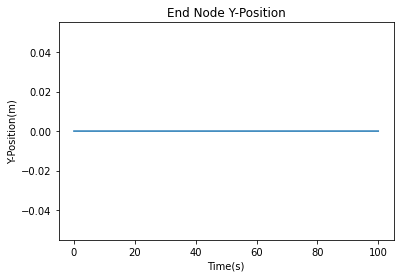

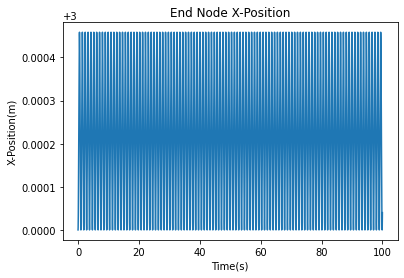

In [8]:
time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.title("End Node Z-Position")
plt.xlabel("Time(s)")
plt.ylabel("Z-Position(m)")
plt.figure()
plt.plot(time_history, position_history[-1,0,:])
plt.title("End Node Y-Position")
plt.xlabel("Time(s)")
plt.ylabel("Y-Position(m)")
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
plt.title("End Node X-Position")
plt.xlabel("Time(s)")
plt.ylabel("X-Position(m)")

In [11]:
position_history.shape

(3, 11, 33334)

## Save Position Data to create POVray vis

In [13]:
import pickle as pk
filename = "milestone1_vis.dat"
file = open(filename, "wb")
pk.dump(position_history, file)
file.close()